In [154]:
import pandas as pd

brent_oil_df_raw = pd.read_csv("data/GasOtherFutures/individual_data/Brent_Crude_Oil_data.csv")
display(brent_oil_df_raw)

,date,open,high,low,close,volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,4387
...,...,...,...,...,...,...
4124,2024-03-11,81.910004,82.730003,81.080002,82.209999,28619
4125,2024-03-12,82.430000,83.010002,81.690002,81.919998,29951
4126,2024-03-13,82.389999,84.220001,81.970001,84.029999,34043
4127,2024-03-14,83.980003,85.680000,83.940002,85.419998,34250


In [163]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = np.full((brent_oil_df_raw['date'].size, 4), np.nan)
close_columns = pd.MultiIndex.from_product([['Close value'], ['Original', 'Predicted'], ['Scaled', 'Normalized']])
brent_oil_close_df = pd.DataFrame(
    data,
    index=pd.to_datetime(brent_oil_df_raw['date']),
    columns=close_columns)
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Scaled')] =\
    brent_oil_df_raw['close'].to_numpy()
scaler_ = MinMaxScaler().fit(brent_oil_df_raw['close'].to_numpy().reshape(-1, 1))
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Normalized')] =\
    scaler_.transform(brent_oil_df_raw['close'].to_numpy().reshape(-1, 1)).flatten()
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-11   82.209999   0.496095       NaN        NaN
2024-03-12   81.919998   0.493807       NaN        NaN
2024-03-13   84.029999   0.510454       NaN        NaN
2024-03-14   85.419998   0.521420       NaN        NaN
2024-03-15   85.339996   0.520789       NaN        NaN

[4129 rows x 4 columns]

In [164]:
# Using business day frequency
brent_oil_close_df = brent_oil_close_df.asfreq('B')
brent_oil_close_df.interpolate('time', inplace=True)
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-11   82.209999   0.496095       NaN        NaN
2024-03-12   81.919998   0.493807       NaN        NaN
2024-03-13   84.029999   0.510454       NaN        NaN
2024-03-14   85.419998   0.521420       NaN        NaN
2024-03-15   85.339996   0.520789       NaN        NaN

[4340 rows x 4 columns]

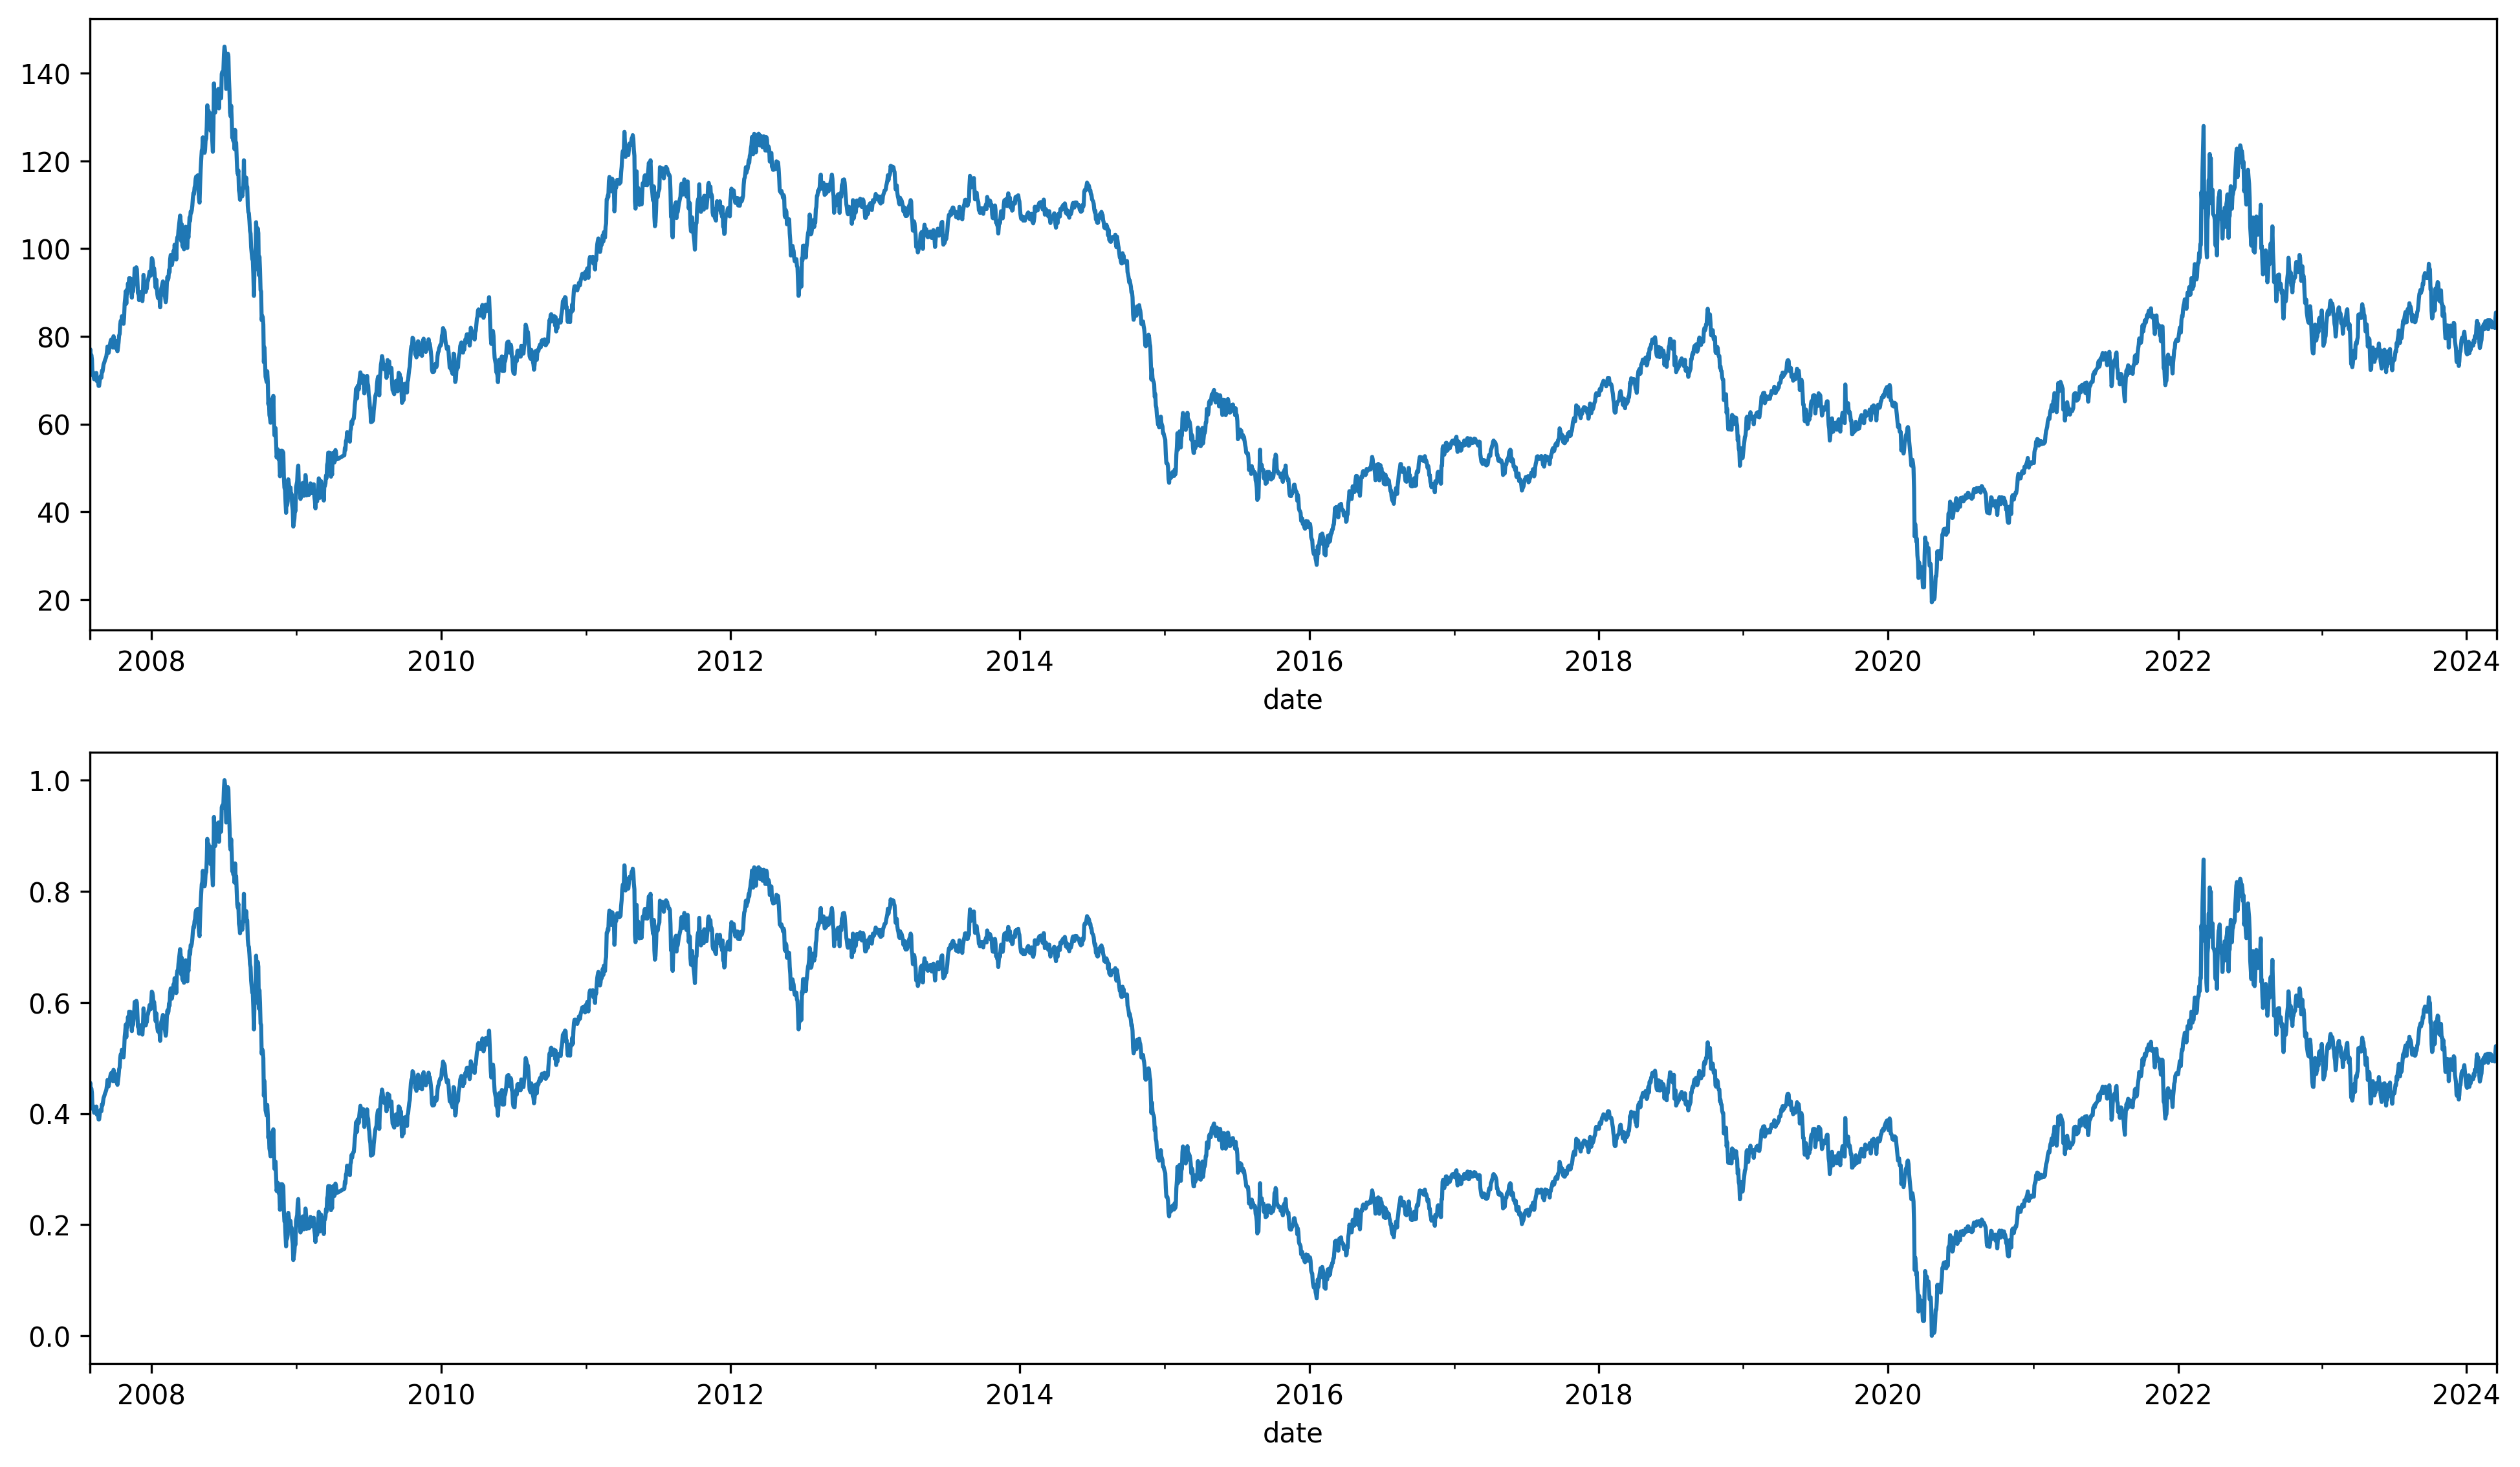

In [166]:
import matplotlib.pyplot as plt

# Comparing plots for scaled and normalized data (should look the same)
fig, axs = plt.subplots(2, 1, figsize=(16, 9))
brent_oil_close_df['Close value']['Original']['Scaled'].plot(ax=axs[0])
brent_oil_close_df['Close value']['Original']['Normalized'].plot(ax=axs[1])
plt.gcf().set_dpi(300)
plt.show()